In [9]:
# Standard data science libraries
import pandas as pd
import copy
import numpy as np
from datetime import datetime
from sklearn.impute import SimpleImputer
# Visualization
import seaborn as sns
sns.set()
import matplotlib
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from countrygroups import EUROPEAN_UNION
import re
import os.path 
%matplotlib inline
import pycountry
from googletrans import Translator
import glob
import geopy

In [60]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US')
EU_countries = EUROPEAN_UNION.names
path = "C:/Users/yacco/Documents/TUM/Applied Machine Learning/group16/data/Tripadvisor_datasets/*.csv"

In [88]:
def get_file(path):
    file_names = []
    data = pd.DataFrame()
    names = glob.glob(path)
    for i in range (len(names)): 
        df = pd.read_csv(names[i],header=0, squeeze=True)
        file_name = os.path.basename(names[i])
        file_name = file_name.split('.')[0]
        file_names.append(file_name)
        visitors_by_country, type_of_visitors, visitors_by_city = feature_extraction(df, file_name)
        visitors_by_country = eu_countries (visitors_by_country)
        visitors_from_munich, visitors_outside_munich, visitors_outside_eu, visitors_from_eu = get_visitors(visitors_by_country, visitors_by_city)
        type_of_visitors['visitors_from_munich'] = visitors_from_munich
        type_of_visitors['visitors_outside_munich'] = visitors_outside_munich
        type_of_visitors['visitors_outside_eu'] = visitors_outside_eu
        type_of_visitors['visitors_from_eu'] = visitors_from_eu
        type_of_visitors['attraction_name'] = file_name
        data = data.append(type_of_visitors)
        

        print(file_name)
    data.reset_index()
    data.set_index('attraction_name' , inplace=True)
    data[['Traveled on business' , 'Traveled solo' , 'Traveled with friends' , 'Traveled as a couple' , 'Traveled with family'  ]] = data[['Traveled on business' , 'Traveled solo' , 'Traveled with friends' , 'Traveled as a couple' , 'Traveled with family'  ]].div(data[['Traveled on business' , 'Traveled solo' , 'Traveled with friends' , 'Traveled as a couple' , 'Traveled with family' ]].sum(axis=1), axis=0)
    data[['visitors_from_munich' , 'visitors_outside_munich' , 'visitors_outside_eu' , 'visitors_from_eu']] =  data[['visitors_from_munich' , 'visitors_outside_munich' , 'visitors_outside_eu' , 'visitors_from_eu']].div(data[['visitors_from_munich' , 'visitors_outside_munich' , 'visitors_outside_eu' , 'visitors_from_eu']].sum(axis=1), axis=0)
    data.to_csv('k_means_data.csv')  
    
    return data

data= get_file(path)
        


Allianz Arena
Alte Pinakothek
Asamkirche Munich
BMW Museum
Deutsches Museum
Eisbach
English Garden
Lenbachhaus
Marienplatz
Munchener Tierpark Hellabrunn
Munich Residenz
Museum Brandhorst
Neues Rathaus Munich
Nymphenburg Palace
Olympiapark
Olympiaturm
Pinakothek der Moderne
St-Peter Munich
Viktualienmarkt


In [89]:
len(data)

19

In [42]:
Eisbach_Wave = pd.read_csv('C:/Users/yacco/Documents/TUM/Applied Machine Learning/group16/Tripadvisor_web_scraper/Updated Datasets/Eisbach Wave.csv',  header=0, squeeze=True)
Eisbach_Wave = preprocessing(Eisbach_Wave)
Eisbach_Wave= clustering_process(Eisbach_Wave)

ValueError: Columns must be same length as key

In [1]:
def preprocessing(df):
    df['date'] = df['date'].replace({'Date of experience: ': ''}, regex=True)
    df['date'] = df['date'].replace({'Date of experience: ': ''}, regex=True)
    df['visit'] = df['visit'].replace({'Trip type: ': ''}, regex=True)
    df['date']= [datetime.strptime(date, '%B %Y')for date in df['date']]
    df = df.sort_values(by='date', ascending=False, inplace=False, ignore_index=True)
    #df['date'] = df['date'].dt.strftime('%Y-%m')
    df = df.set_index('date')
    

    return df

In [53]:
def clustering_process(df):
    df[['city', 'country']] = df['visitor_origin'].str.split(', ', expand=True, n=1)
    df = df.drop(['rating','title','text'], axis=1)
    return df

In [3]:
def get_season(df):
    summer_pre_covid = df[(df.index >= '2019-06-1') & (df.index <= '2019-08-01')]
    winter_pre_covid = df[(df.index >= '2019-09-1') & (df.index <= '2020-02-01')]
    winter_post_covid = df[(df.index >= '2020-03-01') & (df.index <= '2020-05-01')]
    summer_post_covid = df[(df.index >= '2020-06-01')]
    
    return summer_pre_covid, winter_pre_covid,winter_post_covid, summer_post_covid

In [55]:
def feature_extraction(df, file_name):
    df = preprocessing(df)
    df = clustering_process(df)
    visitors_by_country = df.groupby('country').count().sort_values('visit', ascending=True)
    type_of_visitors    = df.groupby('visit').count().sort_values('country', ascending=True)
    type_of_visitors    = type_of_visitors.T.drop(index=['city', 'country'])
    visitors_by_city    = df.groupby('city').count().sort_values('visit', ascending=True)
    type_of_visitors.index.rename(file_name)
    return visitors_by_country, type_of_visitors, visitors_by_city


In [5]:
def eu_countries(visitors_by_country): 
    visitors_by_country["Non EU"] = 0
    for i in range (len(visitors_by_country)):
        if not(visitors_by_country.index[i] in EU_countries):
            visitors_by_country["Non EU"][i] = int(1)
    return visitors_by_country

In [6]:
def get_visitors(visitors_by_country, visitors_by_city):
    
    visitors_from_munich    = visitors_by_city['visitor_origin']['Munich']
    visitors_outside_munich = visitors_by_country['visitor_origin']['Germany']- visitors_by_city['visitor_origin']['Munich']
    visitors_outside_eu     = visitors_by_country.groupby('Non EU').sum()['visitor_origin'][1]
    visitors_from_eu        = visitors_by_country.groupby('Non EU').sum()['visitor_origin'][0] - visitors_by_country['visitor_origin']['Germany']
    return visitors_from_munich, visitors_outside_munich, visitors_outside_eu, visitors_from_eu
    

In [10]:
file_path = glob.glob('/Users/yacco/Documents/TUM/Applied Machine Learning/group16/Tripadvisor_web_scraper/Preprocessed Datasets/*.csv')

In [16]:
Englischer_Garten = pd.read_csv('C:/Users/yacco/Documents/TUM/Applied Machine Learning/group16/Tripadvisor_web_scraper/Updated Datasets/English Garden.csv',  header=0, squeeze=True)
visitors_by_country, type_of_visitors, visitors_by_city = feature_extraction(Englischer_Garten, file_name)
visitors_by_country = eu_countries (visitors_by_country)
visitors_from_munich, visitors_outside_munich, visitors_outside_eu, visitors_from_eu = get_visitors(visitors_by_country, visitors_by_city)

In [37]:
Englischer_Garten = pd.read_csv('C:/Users/yacco/Documents/TUM/Applied Machine Learning/group16/Tripadvisor_web_scraper/Updated Datasets/English Garden.csv',  header=0, squeeze=True)
Englischer_Garten = preprocessing(Englischer_Garten)
Englischer_Garten = clustering_process(Englischer_Garten)


,visitor_origin,visit,country,extra,city_Aachen,city_Aalborg,city_Aberdeen,city_Abu Dhabi,city_Accrington,city_Adelaide,...,city_Zurich,city_falls church,city_milano,city_montreal,city_paris,city_roma,city_scotland,city_seek4fun,city_tarragona,city_東京
date,,,,,,,,,,,,,,,,,,,,,
2020-08-01,"Kinross, United Kingdom",NaN,United Kingdom,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-08-01,"Frederiksberg, Denmark",NaN,Denmark,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-08-01,"Ermenonville, France",Traveled solo,France,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-08-01,"Eindhoven, The Netherlands",Traveled as a couple,The Netherlands,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-08-01,"Frederiksberg, Denmark",Traveled as a couple,Denmark,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
Englischer_Garten

,visitor_origin,visit,city,country,extra
date,,,,,
2020-08-01,"Kinross, United Kingdom",NaN,Kinross,United Kingdom,None
2020-08-01,"Frederiksberg, Denmark",NaN,Frederiksberg,Denmark,None
2020-08-01,"Ermenonville, France",Traveled solo,Ermenonville,France,None
2020-08-01,"Eindhoven, The Netherlands",Traveled as a couple,Eindhoven,The Netherlands,None
2020-08-01,"Frederiksberg, Denmark",Traveled as a couple,Frederiksberg,Denmark,None
...,...,...,...,...,...
2018-09-01,NaN,NaN,NaN,NaN,NaN
2018-09-01,"Boston, MA, United States",NaN,Boston,MA,United States
2018-09-01,"Papeete, French Polynesia",NaN,Papeete,French Polynesia,None


In [77]:
def binary_encoding(df):
    df = preprocessing(df)
    df = clustering_process(df)
    df = df.reset_index()
    df['provenance'] = ''
    for index, row in df.iterrows():        
        if df['city'][index] == 'Munich':
            df['provenance'][index] = 'Munich'
        elif df['country'][index] == 'Germany' and df['city'][index] != 'Munich':
            df['provenance'][index] = 'outside Munich'
        elif df['country'][index] in EU_countries and df['country'][index] != 'Germany' : 
            df['provenance'][index] = 'EU apart from GER'
        else :
            df['provenance'][index] = 'Outisde EU'
    df = pd.get_dummies(df, columns=["provenance" , "visit"])
    df = df.set_index('date')

    return df

In [78]:
Englischer_Garten = pd.read_csv('C:/Users/yacco/Documents/TUM/Applied Machine Learning/group16/Tripadvisor_web_scraper/Updated Datasets/English Garden.csv',  header=0, squeeze=True)
Englischer_Garten = binary_encoding(Englischer_Garten)
Englischer_Garten

C:\Users\yacco\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\yacco\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\yacco\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\yacco\anac

,visitor_origin,city,country,extra,provenance_EU apart from GER,provenance_Munich,provenance_Outisde EU,provenance_outside Munich,visit_Traveled as a couple,visit_Traveled on business,visit_Traveled solo,visit_Traveled with family,visit_Traveled with friends
date,,,,,,,,,,,,,
2020-08-01,"Kinross, United Kingdom",Kinross,United Kingdom,None,1,0,0,0,0,0,0,0,0
2020-08-01,"Frederiksberg, Denmark",Frederiksberg,Denmark,None,1,0,0,0,0,0,0,0,0
2020-08-01,"Ermenonville, France",Ermenonville,France,None,1,0,0,0,0,0,1,0,0
2020-08-01,"Eindhoven, The Netherlands",Eindhoven,The Netherlands,None,0,0,1,0,1,0,0,0,0
2020-08-01,"Frederiksberg, Denmark",Frederiksberg,Denmark,None,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-01,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0
2018-09-01,"Boston, MA, United States",Boston,MA,United States,0,0,1,0,0,0,0,0,0
2018-09-01,"Papeete, French Polynesia",Papeete,French Polynesia,None,0,0,1,0,0,0,0,0,0


In [72]:
df = pd.get_dummies(Englischer_Garten, columns=["provenance"])
df


,date,visitor_origin,visit,city,country,extra,provenance_EU apart from GER,provenance_Munich,provenance_Outisde EU,provenance_outside Munich
0,2020-08-01,"Kinross, United Kingdom",NaN,Kinross,United Kingdom,None,1,0,0,0
1,2020-08-01,"Frederiksberg, Denmark",NaN,Frederiksberg,Denmark,None,1,0,0,0
2,2020-08-01,"Ermenonville, France",Traveled solo,Ermenonville,France,None,1,0,0,0
3,2020-08-01,"Eindhoven, The Netherlands",Traveled as a couple,Eindhoven,The Netherlands,None,0,0,1,0
4,2020-08-01,"Frederiksberg, Denmark",Traveled as a couple,Frederiksberg,Denmark,None,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
850,2018-09-01,NaN,NaN,NaN,NaN,NaN,0,0,1,0
851,2018-09-01,"Boston, MA, United States",NaN,Boston,MA,United States,0,0,1,0
852,2018-09-01,"Papeete, French Polynesia",NaN,Papeete,French Polynesia,None,0,0,1,0
853,2018-09-01,NaN,NaN,NaN,NaN,NaN,0,0,1,0


In [76]:
Englischer_Garten = pd.read_csv('English Garden.csv',  header=0, squeeze=True)
Englischer_Garten = preprocessing(Englischer_Garten)
Englischer_Garten = clustering_process(Englischer_Garten)
Englischer_Garten_summer_pre, Englischer_Garten_winter_pre, Englischer_Garten_winter_post, Englischer_Garten_summer_post = get_season(Englischer_Garten)

In [78]:
Englischer_Garten_summer_pre

,visitor_origin,visit,city,country,extra
date,,,,,
2019-08-01,NaN,Traveled with family,NaN,NaN,NaN
2019-08-01,"Istanbul, Turkey",Traveled with family,Istanbul,Turkey,None
2019-08-01,"Uppsala, Sweden",Traveled as a couple,Uppsala,Sweden,None
2019-08-01,"Montevideo, Uruguay",NaN,Montevideo,Uruguay,None
2019-08-01,"Munich, Germany",NaN,Munich,Germany,None
...,...,...,...,...,...
2019-06-01,NaN,Traveled as a couple,NaN,NaN,NaN
2019-06-01,"Crystal Lake, Illinois",NaN,Crystal Lake,Illinois,None
2019-06-01,NaN,NaN,NaN,NaN,NaN


In [70]:
df_pre_covid = Englischer_Garten[(Englischer_Garten.index > '2019-08-1') & (Englischer_Garten.index <= '2020-03-01')]

In [71]:
df_pre_covid

,visitor_origin,visit,city,country,extra
date,,,,,
2020-03-01,"Gualtieri, Italy",NaN,Gualtieri,Italy,None
2020-03-01,"Freising, Germany",NaN,Freising,Germany,None
2020-03-01,"Munich, Germany",Traveled as a couple,Munich,Germany,None
2020-03-01,"Lancashire, United Kingdom",NaN,Lancashire,United Kingdom,None
2020-03-01,"Lund, Sweden",Traveled with friends,Lund,Sweden,None
...,...,...,...,...,...
2019-09-01,NaN,NaN,NaN,NaN,NaN
2019-09-01,"Castle Rock, Colorado",Traveled with family,Castle Rock,Colorado,None
2019-09-01,"Neuffen, Germany",NaN,Neuffen,Germany,None


In [ ]:
plt.rc("figure")
visitors_by_country['visit'].plot(kind='barh', color='grey')
sns.despine()
plt.title('Number of unique visitors by countries', loc='left', size=17)
plt.legend("")
plt.ylabel("")

In [ ]:
type_of_visitors

In [ ]:
plt.rc("figure", figsize=(8, 7))
type_of_visitors.plot(kind='barh', color='grey')
sns.despine()
plt.title('Attraction by type of visit', loc='left', size=17)
plt.legend("")
plt.ylabel("")

In [ ]:
def clustering_preprocessing(dataframe):
    df = dataframe.copy()
    df['date'] = df['date'].replace({'Erlebnisdatum: ': ''}, regex=True)
    df['visit'] = df['visit'].replace({'Reiseart: ': ''}, regex=True)
    df[['city', 'country']] = df['visitor_origin'].str.split(',', expand=True, n=2)
    df = pd.get_dummies(df, columns=["visit", "country"])
    df = df.drop(['rating'], axis=1)
    return df

In [ ]:
data

In [ ]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot

In [ ]:
model = KMeans(n_clusters=3)

In [ ]:
model.fit()

In [ ]:
yhat = model.predict(data)
# retrieve unique clusters
clusters = unique(yhat)


In [ ]:
pyplot.scatter()

In [ ]:
y = KMeans.predict(data)
data['cluster'] = y
pandas.tools.plotting.parallel_coordinates(data, 'cluster')

In [ ]:
kmeans = KMeans(n_clusters=3)

y = kmeans.fit_predict(data)
data['Cluster'] = y

print(data.head())

In [ ]:
data

In [68]:
data

,Traveled on business,Traveled solo,Traveled with friends,Traveled as a couple,Traveled with family,visitors_from_munich,visitors_outside_munich,visitors_outside_eu,visitors_from_eu
attraction_name,,,,,,,,,
Allianz Arena,0.044271,0.072917,0.239583,0.244792,0.398438,0.046316,0.147368,0.376842,0.429474
Alte Pinakothek,0.039130,0.195652,0.204348,0.365217,0.195652,0.083916,0.118881,0.496503,0.300699
Asamkirche,NaN,0.086957,0.086957,0.478261,0.347826,0.044643,0.062500,0.571429,0.321429
Bavarian National Museum,NaN,0.178571,0.214286,0.428571,0.178571,0.065789,0.039474,0.539474,0.355263
Bayerische Staatsoper,0.028169,0.140845,0.197183,0.507042,0.126761,0.088496,0.150442,0.371681,0.389381
BMW Museum,0.072100,0.115987,0.216301,0.366771,0.228840,0.043038,0.027848,0.612658,0.316456
Deutsches Museum,0.028777,0.071942,0.179856,0.258993,0.460432,0.079070,0.186047,0.348837,0.386047
Eisbach Wave,NaN,0.187500,0.250000,0.187500,0.375000,0.043103,0.129310,0.465517,0.362069
English Garden,0.014286,0.097143,0.205714,0.408571,0.274286,0.077863,0.119084,0.416794,0.386260


In [69]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot

In [ ]:
yhat = model.predict(data)
# retrieve unique clusters
clusters = unique(yhat)


In [74]:
data

,Traveled on business,Traveled solo,Traveled with friends,Traveled as a couple,Traveled with family,visitors_from_munich,visitors_outside_munich,visitors_outside_eu,visitors_from_eu
attraction_name,,,,,,,,,
Allianz Arena,0.044271,0.072917,0.239583,0.244792,0.398438,0.046316,0.147368,0.376842,0.429474
Alte Pinakothek,0.039130,0.195652,0.204348,0.365217,0.195652,0.083916,0.118881,0.496503,0.300699
Asamkirche,NaN,0.086957,0.086957,0.478261,0.347826,0.044643,0.062500,0.571429,0.321429
Bavarian National Museum,NaN,0.178571,0.214286,0.428571,0.178571,0.065789,0.039474,0.539474,0.355263
Bayerische Staatsoper,0.028169,0.140845,0.197183,0.507042,0.126761,0.088496,0.150442,0.371681,0.389381
BMW Museum,0.072100,0.115987,0.216301,0.366771,0.228840,0.043038,0.027848,0.612658,0.316456
Deutsches Museum,0.028777,0.071942,0.179856,0.258993,0.460432,0.079070,0.186047,0.348837,0.386047
Eisbach Wave,NaN,0.187500,0.250000,0.187500,0.375000,0.043103,0.129310,0.465517,0.362069
English Garden,0.014286,0.097143,0.205714,0.408571,0.274286,0.077863,0.119084,0.416794,0.386260


In [77]:
y = KMeans.predict(data)
data['cluster'] = y
pandas.tools.plotting.parallel_coordinates(data, 'cluster')

TypeError: predict() missing 1 required positional argument: 'X'

In [83]:
from yellowbrick.cluster import KElbowVisualizer

C:\Users\yacco\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [93]:
kmeans = KMeans(n_clusters=4)
data= data.fillna(0)
y = kmeans.fit_predict(data)
data['Cluster'] = y


In [94]:
data

,Traveled on business,Traveled solo,Traveled with friends,Traveled as a couple,Traveled with family,visitors_from_munich,visitors_outside_munich,visitors_outside_eu,visitors_from_eu,Cluster
attraction_name,,,,,,,,,,
Allianz Arena,0.044271,0.072917,0.239583,0.244792,0.398438,0.046316,0.147368,0.376842,0.429474,2
Alte Pinakothek,0.039130,0.195652,0.204348,0.365217,0.195652,0.083916,0.118881,0.496503,0.300699,0
Asamkirche Munich,0.000000,0.086957,0.086957,0.478261,0.347826,0.044643,0.062500,0.571429,0.321429,0
BMW Museum,0.072100,0.115987,0.216301,0.366771,0.228840,0.043038,0.027848,0.612658,0.316456,0
Deutsches Museum,0.028777,0.071942,0.179856,0.258993,0.460432,0.079070,0.186047,0.348837,0.386047,2
Eisbach,0.000000,0.187500,0.250000,0.187500,0.375000,0.043103,0.129310,0.465517,0.362069,2
English Garden,0.014286,0.097143,0.205714,0.408571,0.274286,0.077863,0.119084,0.416794,0.386260,0
Lenbachhaus,0.000000,0.625000,0.000000,0.250000,0.125000,0.307692,0.025641,0.410256,0.256410,1
Marienplatz,0.065401,0.088608,0.223629,0.405063,0.217300,0.033632,0.073991,0.528027,0.364350,0


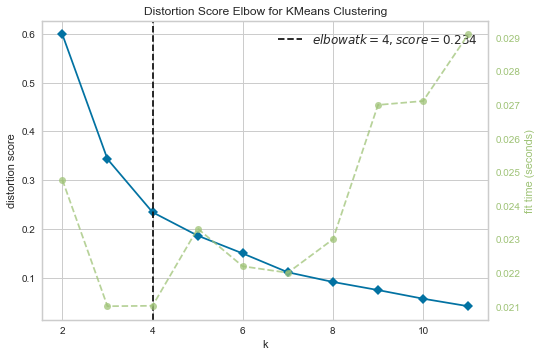

In [92]:
visualizer = KElbowVisualizer(kmeans, k=(2,12))
data= data.fillna(0)

visualizer.fit(data)       
visualizer.show() 

In [81]:
data

,Traveled on business,Traveled solo,Traveled with friends,Traveled as a couple,Traveled with family,visitors_from_munich,visitors_outside_munich,visitors_outside_eu,visitors_from_eu,Cluster
attraction_name,,,,,,,,,,
Allianz Arena,0.044271,0.072917,0.239583,0.244792,0.398438,0.046316,0.147368,0.376842,0.429474,0
Alte Pinakothek,0.039130,0.195652,0.204348,0.365217,0.195652,0.083916,0.118881,0.496503,0.300699,1
Asamkirche,0.000000,0.086957,0.086957,0.478261,0.347826,0.044643,0.062500,0.571429,0.321429,1
Bavarian National Museum,0.000000,0.178571,0.214286,0.428571,0.178571,0.065789,0.039474,0.539474,0.355263,1
Bayerische Staatsoper,0.028169,0.140845,0.197183,0.507042,0.126761,0.088496,0.150442,0.371681,0.389381,1
BMW Museum,0.072100,0.115987,0.216301,0.366771,0.228840,0.043038,0.027848,0.612658,0.316456,1
Deutsches Museum,0.028777,0.071942,0.179856,0.258993,0.460432,0.079070,0.186047,0.348837,0.386047,0
Eisbach Wave,0.000000,0.187500,0.250000,0.187500,0.375000,0.043103,0.129310,0.465517,0.362069,0
English Garden,0.014286,0.097143,0.205714,0.408571,0.274286,0.077863,0.119084,0.416794,0.386260,1
